In [1]:
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.15.0


Load MNIST dataset and separate training and test data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(y_train[:100])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]


Check the distribution of the label count of the training data

<Axes: ylabel='count'>

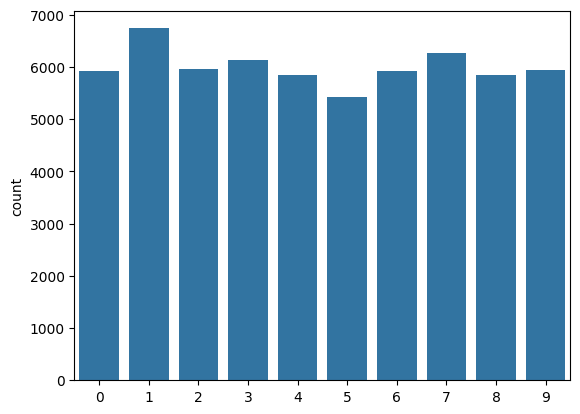

In [4]:
sns.countplot(x = y_train)

Check if there is any NaN

In [5]:
np.isnan(x_train).any()
np.isnan(x_test).any()

False

Normalize and reshape the training and test input

In [6]:
input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

Transform the labels into one-hot encodings

In [7]:
y_train = tf.one_hot(y_train.astype(np.int32), depth = 10)
y_test = tf.one_hot(y_test.astype(np.int32), depth = 10)

Check some random training image and the corresponding label

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


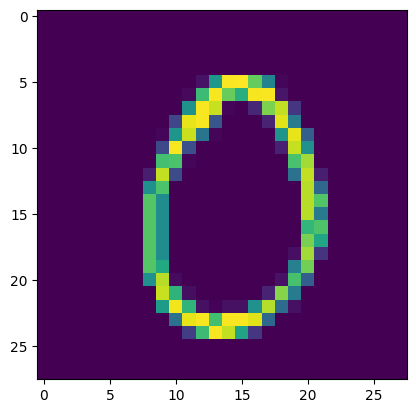

In [8]:
plt.imshow(x_train[210][:,:,0])
print(y_train[210])

Build the model

In [9]:
batch_size = 64
num_classes = 10
epochs = 5

In [10]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (5,5), padding = 'same', activation = 'relu', input_shape = input_shape),
tf.keras.layers.Conv2D(32, (5,5), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPool2D(),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPool2D(strides = (2,2)),
tf.keras.layers.Dropout(0.25, name = 'target_layer'),  # Our target layer
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(num_classes, activation = 'linear'),
tf.keras.layers.Activation('softmax', name = 'softmax')])

model.compile(optimizer = tf.keras.optimizers.RMSprop(epsilon = 1e-08), loss = 'categorical_crossentropy', metrics = ['acc'])

Define the callback

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') > 0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Train the model

In [12]:
train_model = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = 0.1,
                    callbacks = [callbacks])

Epoch 1/5


844/844 [==============================] - 60s 70ms/step - loss: 0.2343 - acc: 0.9261 - val_loss: 0.0411 - val_acc: 0.9875
Epoch 2/5
844/844 [==============================] - 41s 48ms/step - loss: 0.0761 - acc: 0.9775 - val_loss: 0.0544 - val_acc: 0.9865
Epoch 3/5
844/844 [==============================] - 38s 44ms/step - loss: 0.0583 - acc: 0.9836 - val_loss: 0.0368 - val_acc: 0.9912
Epoch 4/5
844/844 [==============================] - 41s 49ms/step - loss: 0.0498 - acc: 0.9856 - val_loss: 0.0287 - val_acc: 0.9933
Epoch 5/5
844/844 [==============================] - 48s 57ms/step - loss: 0.0427 - acc: 0.9873 - val_loss: 0.0284 - val_acc: 0.9943


Save the model for the CAM

In [13]:
model.save('model.h5')

c:\Users\ShunJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate the accuracy of the model

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0220 - acc: 0.9931


Visualize the result of some input to the model

1/1 [==============================] - 0s 83ms/step
9


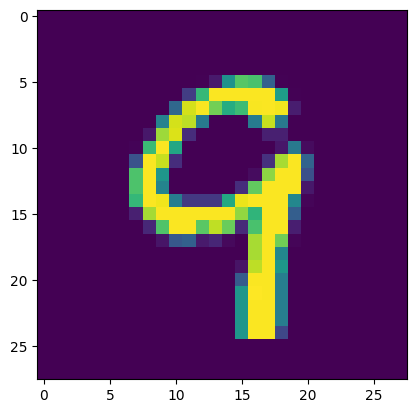

In [15]:
model1 = load_model('model.h5')
plt.imshow(x_test[150][:,:,0])
prediction = model1.predict(x_test[150].reshape(1, 28, 28, 1))
print(np.argmax(prediction))